In [195]:
import pandas as pd
import os
import re
from datetime import datetime
from dateutil.relativedelta import relativedelta
import json
from tqdm import tqdm

In [145]:
def roundTime(dt=None, roundTo=60):
    if dt == None: 
        dt = datetime.now()
    seconds = (dt.replace(tzinfo=None) - dt.min).seconds
    rounding = (seconds+roundTo/2) // roundTo * roundTo
    return dt + timedelta(0,rounding-seconds,-dt.microsecond)

In [239]:
# The following runs through all my files and stores the path and other data if the file extension is .py or .ipynb 
rootdir = r'C:\Users\Art Perkitny\Dropbox'

df = pd.DataFrame(columns=['file','c_time', 'm_time','lines','pandas'])

for subdir, dirs, files in tqdm(os.walk(rootdir)):
    for file in files:
        file_end = re.findall("([^\.]+$)", file)
        if not file_end:
            continue
        if file_end[0] in ['py','ipynb']:
            file = os.path.join(subdir, file)
            unix_t_c = os.path.getctime(os.path.join(subdir, file))
            unix_t_m = os.path.getmtime(os.path.join(subdir, file))
            date_time_c = datetime.utcfromtimestamp(unix_t_c)
            date_time_m = datetime.utcfromtimestamp(unix_t_m)
            df = df.append({'file':file, 'c_time':date_time_c, 'm_time':date_time_m}, ignore_index=True)

9631it [01:11, 134.89it/s] 


In [241]:
# Filter dataframe for files that have been modifed within the past 6 months
df = df.loc[df['m_time']>=datetime.today() - relativedelta(months=+6)]

In [243]:
# Apply time rounding function to both file create and modify time
# This was used to filter out any files that were created and never modifed to eliminate files that I did not make (library files and such) but it did not work very well
df.c_time = df.c_time.apply(roundTime)
df.m_time = df.m_time.apply(roundTime)
# df = df.loc[df['c_time']!=df['m_time']]

In [250]:
# Lambda function to exclude all paths within ipynb_checkpoints directories
df = df.loc[~df.file.apply(lambda x: '.ipynb_checkpoints' in x)]
# Filter out all files in Tensorflow Object Detection models directory and other directories that contain code I did not personally write
df = df.loc[~df['file'].str.contains(r"\\models\\research\\")]
df = df.loc[~df['file'].str.contains(r"\\env\\")]
df = df.loc[~df['file'].str.contains(r"\\.dropbox.cache\\")]
df = df.loc[~df['file'].str.contains(r"\\models\\official")]

In [251]:
len(df)

303

In [252]:
for n, row in tqdm(df.iterrows(),total=len(df)):
    if '.ipynb_checkpoints' in row.file:
        continue
#     print(row.file)
    contains_pandas = False
    f = open(row.file, "r")
    try:
        text = f.read()
        file_end = re.findall("([^\.]+$)", row.file)[0]
        if file_end == 'ipynb':
            lines = 0
            for cell in json.loads(text)['cells']:
                if cell['cell_type'] == 'code':
    #                 print(cell["source"])
                    lines += len(cell["source"])
                    for line in cell["source"]:
                        if 'import pandas' in line:
                            contains_pandas = True
        else:
            lines = 0
            for line in text.split('\n'):
                if 'import pandas' in line:
                        contains_pandas = True
                lines+=1

        df.loc[n, 'lines'] = lines
        df.loc[n, 'pandas'] = contains_pandas
        
    except Exception as e:
#         print(e)
        pass
    

100%|███████████████████████████████████████████████████████████████████████████████| 303/303 [00:01<00:00, 294.75it/s]


In [287]:
df = df.loc[df['pandas']==True]

In [288]:
df.lines.sum()

8428

In [290]:
df.loc[df['file'].str.contains("Pandas LInes")]

,file,c_time,m_time,lines,pandas
12136,C:\Users\Art Perkitny\Dropbox\Notebooks\Pandas...,2020-10-15 00:00:43,2020-10-15 01:12:43,80,True


In [289]:
df.sort_values('lines', ascending=False)[['file','lines','m_time']].style.set_properties(subset=['file'], **{'width': '600px'})

,file,lines,m_time
33,C:\Users\Art Perkitny\Dropbox\Finance Project.ipynb,647,2020-05-16 02:34:43
7,C:\Users\Art Perkitny\Dropbox\BLS and ACS.ipynb,530,2020-07-01 22:59:43
12145,C:\Users\Art Perkitny\Dropbox\Notebooks\Price_to_rent_ratios\Part-4-Alternative-Historical-Data.ipynb,479,2020-07-31 01:46:43
20,C:\Users\Art Perkitny\Dropbox\Cleveland.ipynb,476,2020-05-18 22:49:43
12132,C:\Users\Art Perkitny\Dropbox\Notebooks\Motorcycle Maps\map.ipynb,471,2020-08-24 15:51:43
10167,C:\Users\Art Perkitny\Dropbox\Notebooks\Mentor Collective\Analysis.ipynb,367,2020-08-06 16:02:43
10161,C:\Users\Art Perkitny\Dropbox\Notebooks\HoodScore\main.ipynb,267,2020-09-16 14:04:43
12163,C:\Users\Art Perkitny\Dropbox\Notebooks\SOS_Crawler\Clean_and_make_csv.ipynb,248,2020-10-13 22:11:43
12375,C:\Users\Art Perkitny\Dropbox\Solutions\PyCitySchools\PyCitySchools_Solution.ipynb,234,2020-05-30 13:51:43
28,C:\Users\Art Perkitny\Dropbox\CRM.ipynb,212,2020-08-10 15:37:44


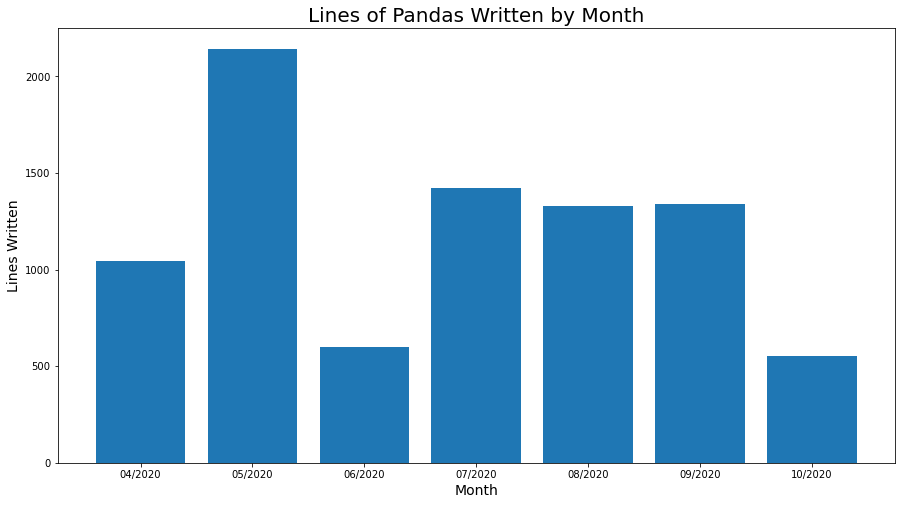

In [314]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))

temp_df = df[['m_time','lines']].groupby(pd.Grouper(key='m_time', freq='M')).agg('sum').reset_index()
temp_df.m_time = temp_df.m_time.apply(lambda x: datetime.strftime(x, "%m/%Y"))

plt.bar(
    x = temp_df['m_time'],
    height  = temp_df['lines'],
#     width = 15
)


plt.xlabel('Month', fontsize=14)
plt.ylabel('Lines Written', fontsize=14)
plt.title('Lines of Pandas Written by Month',  fontsize=20)
plt.savefig('L:/lines_of_pandas.jpg',  dpi=300, bbox_inches = "tight")
plt.show()